# Práctica 6. Autoencoders Variacionales (VAE)

En esta práctica vamos a trabajar con otro conjunto de datos muy conocido, *Fashion MNIST*. Es un conjunto de datos de imágenes de artículos de ropa (de Zalando) considerado la evolución del conjunto MNIST que vimos en la primera práctica porque siguen siendo imágenes pequeñas en blanco y negro pero de mayor complejidad. Cuenta con 60.000 imágenes para el conjunto de entrenamiento y 10.000 para el conjunto de test, todas de 28x28 píxeles. 

Nuestro objetivo durante esta práctica será entrenar un autoencoder variacional a partir de estas imágenes y ser capaces de generar nuestras propias prendas de ropa. Utilizaremos un autoencoder variacional basado en capas densas.

## Importación de las librerías

Es una buena práctica colocar todas las importaciones de librerías al principio de nuestro código. Para este ejercicio solamente nos hará falta utilizar `tensorflow`, `numpy` y `matplotlib`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
## Opciones generales de Matplotlib para ajustar las figuras
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['image.cmap'] = 'binary'

In [3]:
## Este fragmento de código puede servir para solucionar algunos errores de CUDA
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass 

2022-01-06 18:46:43.224659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 18:46:43.233004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 18:46:43.233746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Carga de los datos

Al ser un problema tan estandarizado en el aprendizaje profundo, podemos obtener los datos directamente de la librería *TensorFlow* con la función `tf.keras.datasets.fashion_mnist.load_data()`. Esta función nos devuelve dos conjuntos de datos: el de entrenamiento y el de test.

In [4]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

print(f"Muestras de entrenamiento: {len(X_train)}.")
print(f"Muestras de test: {len(X_test)}.")

Muestras de entrenamiento: 60000.
Muestras de test: 10000.


Recordemos que, al contrario que la librería `tensorflow_datasets`, los conjuntos de datos que cargamos de esta manera son simplemente `arrays` de *NumPy*. Esto no es ningún problema porque ya sabemos trabajar con los dos tipos de formatos, además, es posible crear un `tf.data.Dataset` a partir de uno o varios `array` de *NumPy* con el método `.from_tensor_slices()`. Esto puede sernos de utilidad porque nos permite aprovechar todas las funcionalidades de los `Dataset` de *TensorFlow* que ya hemos visto.

Como en esta práctica solamente queremos utilizar las imágenes de la ropa para generar nuevas, no necesitamos las etiquetas para nada, por lo que no es necesario que las incluyamos:

In [5]:
train = tf.data.Dataset.from_tensor_slices(X_train)
test = tf.data.Dataset.from_tensor_slices(X_test)

len(train), len(test)

2022-01-06 18:46:43.689214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-06 18:46:43.692080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 18:46:43.692677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 18:46:43.693359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

(60000, 10000)

### Exploración de los datos

Siguiendo el procedimiento habitual, podemos representar algunas imágenes del dataset para ver los datos con los que vamos a trabajar:

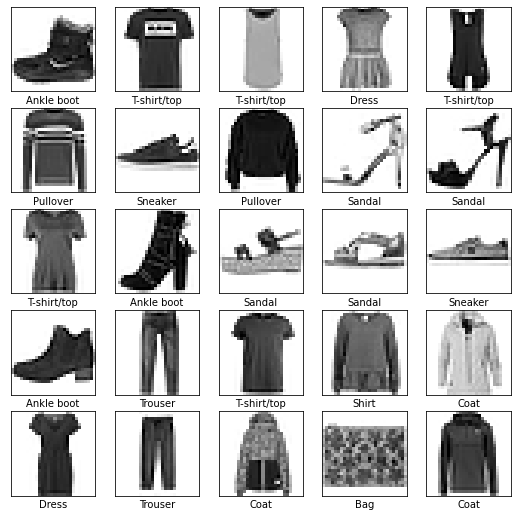

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(9,9))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[Y_train[i]])
# plt.savefig("Images/show_images_grid.png")
plt.show()

También representamos una imagen con su correspondiente barra de color para identificar el rango de los píxeles de las imágenes:

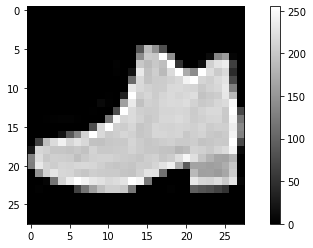

In [115]:
plt.figure()
plt.imshow(X_train[15])
plt.colorbar()
# plt.savefig("Images/boot_colorbar.png")
plt.show()  

El tamaño de las imágenes no hace falta que lo comprobemos porque, sabiendo que provienen de un `array`, sabemos que tienen que tener todas las mismas dimensiones.

## Preprocesado de los datos

Como es habitual, tendremos que normalizar las imágenes al rango $[0,1]$ antes de introducirlas en nuestro modelo. Además, como vamos a utilizar un autoencoder basado únicamente en capas densas, tenemos que "estirar" las imágenes para que tengan la forma de un vector unidimensional que puedan procesar las capas densas. Para "estirar" las imágenes podemos utilizar la función `tf.reshape(tensor, shape=[-1])`. Tampoco podemos olvidar que los autoencoders variacionales se entrenan comparando la imagen de entrada con la imagen de salida, es decir, nuestro `tf.data.Dataset` tendrá que devolver dos veces la misma imagen.

Una de las ventajas de los objetos `tf.data.Dataset` es que podemos encapsular este preprocesado en una función y aplicarla en todos los conjuntos de datos de manera muy cómoda.

**Ejercicio: Otra cosa que podríamos hacer es utilizar como primeras capas del modelo `layers.Flatten()` y `layers.Rescaling()`. Pruébalo.**

In [8]:
def prepare_data(image):

    image = image/255
    image = tf.reshape(image, [-1])
    
    return image, image

In [9]:
train_rdy = train.map(prepare_data)
test_rdy = test.map(prepare_data)

## Definición del modelo

En la práctica anterior ya trabajamos con la arquitectura encoder-decoder, pero ahora le daremos una vuelta de tuerca para hacerla apta para la generación de nuevas muestras. El único cambio que tenemos que hacer es modificar la forma en la que se codifican los datos al espacio latente con el objetivo de que el espacio latente tenga una estructura lo más parecida posible a una distribución normal. Para conseguirlo modificaremos el encoder para que, en lugar de codificar los datos a un solo punto, lo codifique a un punto y su entorno. O lo que es lo mismo, que nos de la media y la desviación estándar del punto en el espacio latente. Una vez tengamos estos dos parámetros podemos utilizar la divergencia de Kullback-Leibler (mide la distancia entre dos distribuciones de probabilidad) para forzar la estructura del espacio latente a la distribución normal. 

Este sutil cambio sirve para que el espacio latente sea en general mucho más continuo, lo que mejora enormemente la generación de datos nuevos a partir del mismo, pero trae consigo una pega muy importante: tal y como se planteaba originalmente esta operación no es diferenciable, por lo que se tiene que utilizar un pequeño truco para poder entrenar el modelo mediante descenso del gradiente.

### Reparametrization Trick

Este truco no es más que utilizar la media y la desviación estándar que nos proporciona el encoder para generar un nuevo valor mediante la expresión:

$$
z = \mu + \epsilon \sigma
$$

dónde $\epsilon$ es un número muy pequeño que extraeremos de una distribución gaussiana de media 0 y desviación estándar 1. 

Para implementarlo definimos una función que tomará los valores de $\mu$ y $\sigma$, y devolverá el valor de $z$. A modo de detalle, normalmente se trabaja con el logaritmo de la desviación estándar porque está definido en todo el espacio y favorece el buen funcionamiento de la red. Más adelante utilizaremos esta función dentro de una capa `layers.Lambda()` que solo acepta una entrada, por eso definimos la función de esta manera.

In [10]:
def reparametrization(input):
    mean, log_sigma = input
    epsilon = tf.random.normal(shape=tf.shape(log_sigma), 
                               mean=0, stddev=1)
    return mean + epsilon*tf.exp(log_sigma)

### API Funcional

La arquitectura que queremos plantear tiene una bifurcación, por lo que tendremos que utilizar o bien la API Funcional o bien herencia de clases. Cada opción tiene sus pros y sus contras, pero como la documentación oficial tiene implementado un modelo similar con herencia de clases (https://www.tensorflow.org/tutorials/generative/cvae), se ha optado por utilizar la API Funcional.

Como el modelo tiene dos partes perfectamente diferenciadas que pueden tener usos distintos, tiene sentido definirlos como dos modelos diferentes y juntarlos posteriormente. No hay que olvidar que podríamos utilizar únicamente el encoder para hacer tareas de compresión o solamente el decoder para generar datos nuevos.

#### Encoder

Consideramos que el encoder es la parte de la red que recibe una imagen y devuelve su ubicación en el espacio latente. Para poder aplicar la función que hemos definido que implementa el *Reparametrization Trick* utilizaremos una capa `layers.Lambda()`, que permite definir una capa con cualquier función que queramos.

Fijaremos una dimensión del espacio latente de 2 para poder realizar algunas representaciones más adelante.

In [102]:
latent_dim = 2

inputs = tf.keras.Input(shape=(784,))
output = layers.Dense(128, activation='relu')(inputs)
mean = layers.Dense(latent_dim)(output)
log_sigma = layers.Dense(latent_dim)(output)
z = layers.Lambda(reparametrization)((mean, log_sigma))
encoder = tf.keras.Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 128)          100480      input_8[0][0]                    
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 2)            258         dense_39[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 2)            258         dense_39[0][0]                   
____________________________________________________________________________________________

#### Decoder

El decoder lo construimos de forma que tenga una función de activación Sigmoide en la última capa porque no podemos tener píxeles negativos. También se puede utilizar una función ReLU.

**Ejercicio: Utiliza una función ReLU como activación de la última capa y compara los resultados. ¿Qué observas?**

In [103]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampleo')
output = layers.Dense(128, activation='relu')(latent_inputs)
output = layers.Dense(784, activation='relu')(output)
decoder = tf.keras.Model(latent_inputs, output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampleo (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_43 (Dense)             (None, 784)               101136    
Total params: 101,520
Trainable params: 101,520
Non-trainable params: 0
_________________________________________________________________


#### Modelo final

Una vez definidas las dos partes, podemos juntarlas de manera sencilla:

In [104]:
output = decoder(encoder(inputs))
model = tf.keras.Model(inputs, output, name='VAE')

model.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 100996    
_________________________________________________________________
decoder (Functional)         (None, 784)               101520    
Total params: 202,516
Trainable params: 202,516
Non-trainable params: 0
_________________________________________________________________


#### Funciones de coste

Como hemos comentado antes, vamos a utilizar la divergencia de Kullback-Leibler para controlar la distribución del espacio latente, pero también tenemos que utilizar el error de reconstrucción para que nuestro modelo aprenda qué tipo de imágenes tiene que generar. Los modelos de *TensorFlow* nos permiten definir funciones de coste de manera similar a cómo se definen los modelos mediante la API Funcional. El primer paso es definir la función que calcule la divergencia KL, que en el caso de una gaussiana de $\mu=0$ y $\sigma=1$ es:

In [105]:
def kl_divergence(mean, log_sigma):
    kl_loss = 1 + log_sigma - tf.square(mean) - tf.exp(log_sigma)
    kl_loss = tf.math.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss

Para calcular el error de reconstrucción se puede utilizar tanto el Error Cuadrático Medio como la Entropía Cruzada, pero esta última favorece que los píxeles tomen valores intermedios y puede producir imágenes más borrosas, así que utilizaremos el *MSE*. De forma nativa *TensorFlow* calcula el error de reconstrucción medio por píxel, por lo que se suele multiplicar por la cantidad de píxeles para equilibrar el peso frente al valor de la divergencia.

**Ejercicio: Utiliza la entropía cruzada y compara los resultados. ¿Ves alguna diferencia?**

In [106]:
kl_loss = kl_divergence(mean, log_sigma)
reconstruction_loss = 784*tf.losses.mean_squared_error(inputs, output)

total_loss = reconstruction_loss + kl_loss
model.add_loss(total_loss)
model.compile(optimizer='adam')

Nuestro modelo ya está listo para ser entrenado:

In [107]:
## Definición de los callbacks
cb_earlystopping = EarlyStopping(patience=4,
                                monitor='val_loss')
cb_modelcheckpoint = ModelCheckpoint(filepath='model_vae_dense.h5',
                                     monitor='val_loss',
                                     save_best_only=True,
                                     save_weights_only=True)

history = model.fit(train_rdy.batch(128),
                    epochs=50,
                    validation_data=test_rdy.batch(128),
                    callbacks=[cb_earlystopping, cb_modelcheckpoint])
model.load_weights('model_vae_dense.h5')

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 50.8150 - val_loss: 44.0761
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 42.2423 - val_loss: 40.5579
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 40.2735 - val_loss: 39.9282
Epoch 4/50
469/469 [==============================] - 5s 10ms/step - loss: 39.7264 - val_loss: 39.4631
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 38.6379 - val_loss: 38.3287
Epoch 6/50
469/469 [==============================] - 5s 12ms/step - loss: 38.1763 - val_loss: 38.0475
Epoch 7/50
469/469 [==============================] - 5s 10ms/step - loss: 37.9637 - val_loss: 37.9083
Epoch 8/50
469/469 [==============================] - 6s 12ms/step - loss: 37.7752 - val_loss: 37.7649
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 37.6091 - val_loss: 37.5588
Epoch 10/50
469/469 [==============================] - 5s 10ms/step - loss:

Representando las dinámicas de entrenamiento vemos que el modelo aprende muy rápido:

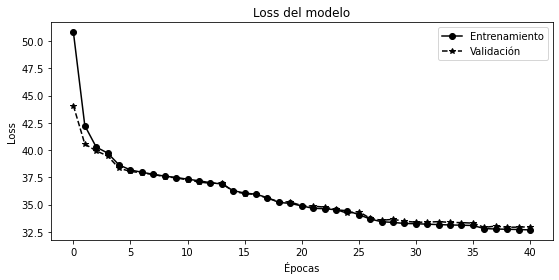

In [108]:
plt.figure()
plt.plot(history.history['loss'], 'k-o', 
            label = "Entrenamiento")
plt.plot(history.history['val_loss'], 'k--*', 
            label = "Validación")
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.title('Loss del modelo')
plt.legend()
# plt.savefig("Images/train_vae.png")
plt.show()

### Comprobando la capacidad de reconstrucción

Una vez hemos entrenado nuestro modelo podemos comprobar qué tal es capaz de reconstruir algunas imágenes del conjunto de test:

In [117]:
n = 8

for img, _ in test_rdy.batch(n):
	img_rec = model.predict(img)
	break

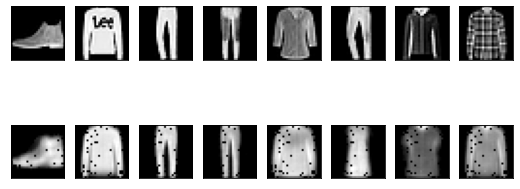

In [121]:
plt.figure()
for i in range(n):
	plt.gray()
	ax = plt.subplot(2, n, i+1)
	plt.imshow(X_test[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

	
	ax = plt.subplot(2, n, i +1+n)
	plt.imshow(img_rec[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
# plt.savefig("Images/reconstructions.png")
plt.show()

Llaman la atención los huecos negros de las imágenes reconstruidas. Esto sucede porque hemos colocado una función ReLU en la última capa. **¿Sucederá lo mismo con la sigmoide? Explica el resultado.**

### Generando prendas de ropa nuevas

Lo último que nos queda por ver cómo utilizar el modelo que hemos entrenado para generar prendas de ropa nuevas. Lo primero a tener en cuenta es que en realidad no nos hace falta utilizar el modelo entero. Para generar imágenes nuevas solamente necesitamos utilizar el decoder.

La idea es generar números aleatorios a partir de una distribución normal, es decir, samplear del espacio latente, e introducirlos en el decoder para obtener imágenes nuevas. Probémoslo:

In [111]:
z = np.random.normal(size=(1, latent_dim))
gen_img = decoder.predict(z)

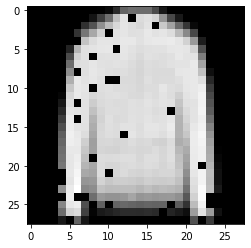

In [122]:
plt.figure()
plt.imshow(gen_img.reshape(28,28))
# plt.savefig("Images/generated_img.png")
plt.show()

También podemos recorrer el espacio latente y representar las imágenes que vamos generado:

In [113]:
n = 15  # imagen de 15x15
tamaño_imagen = 28
figura = np.zeros((tamaño_imagen * n, tamaño_imagen * n))
std_x = np.linspace(-15, 15, n)
std_y = np.linspace(-15, 15, n)
for i, yi in enumerate(std_x):
    for j, xi in enumerate(std_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        ropa = x_decoded[0].reshape(tamaño_imagen, tamaño_imagen)
        figura[i * tamaño_imagen: (i + 1) * tamaño_imagen,
               j * tamaño_imagen: (j + 1) * tamaño_imagen] = ropa

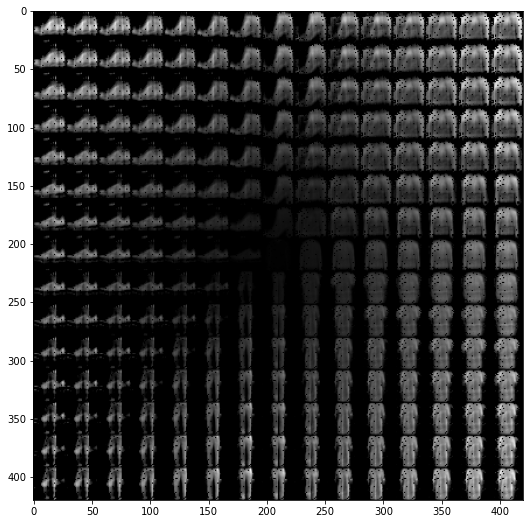

In [124]:
plt.figure(figsize=(9, 9))
plt.imshow(figura, cmap='gray')
# plt.savefig("Images/latent_space.png")
plt.show()

**Ejercicio: Repite el ejercicio utilizando capas convolucionales en lugar de capas densas y compara los resultados. Recuerda que puedes apoyarte en el ejemplo resuelto de la documentación oficial.**